In [1]:
# This file show how we predict novel views that are not presented in the training set

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from vae import FaceVAE
import os
import torch.nn.functional as F
import numpy as np
from data_parser import read_face_data, FaceDataset
import pickle
from gp import GP
from vmod import normalize_rows

def encode_Y(vae, train_queue):
    vae.eval()
    with torch.no_grad():
        n = train_queue.dataset.Y.shape[0]
        Zm = Variable(torch.zeros(n, vae_cfg["zdim"]), requires_grad=False).cuda()
        Zs = Variable(torch.zeros(n, vae_cfg["zdim"]), requires_grad=False).cuda()
        for batch_i, data in enumerate(train_queue):
            y = data[0].cuda()
            idxs = data[-1].cuda()
            zm, zs = vae.encode(y)
            Zm[idxs], Zs[idxs] = zm.detach(), zs.detach()
    return Zm, Zs


vae_cfg = pickle.load(open('out/vae/vae.cfg.p', "rb"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load pretrained VAE weights
vae = FaceVAE(**vae_cfg)
RV = torch.load('out/gppvae/weights/vae_weights.00110.pt')
vae.load_state_dict(RV)
vae.cuda()

gp = GP(n_rand_effs=1)
gp = torch.nn.DataParallel(gp)
gp_weights = torch.load('out/gppvae/weights/gp_weights.00110.pt')
gp.load_state_dict(gp_weights)
gp.to(device)

vm_weights = torch.load('out/gppvae/weights/vm_weights.00110.pt')


ell = vm_weights['ell']
poses60 = np.load('pose60.npy')
poses_eval = np.load('seq_pose.npy')




In [2]:
p1 = poses_eval.shape[0]
p2 = poses60.shape[0]

Did = 0
Dv = torch.tensor(Did*np.ones(60)).long().cuda()


v0 = torch.zeros(p1, p2).cuda()
for i in range(p1):
    for j in range(p2):
        R1 = torch.tensor((poses_eval[i].reshape(3,4))[:3,:3]).float().cuda()
        R2 = torch.tensor((poses60[j].reshape(3,4))[:3,:3]).float().cuda()
        v0[i,j] = torch.exp(-0.5 * torch.trace(torch.exp(torch.diag(ell)) - R1.mm(torch.exp(torch.diag(ell)).mm(R2.transpose(0,1)))))


Xv = F.embedding(Dv, normalize_rows(vm_weights['x0']))  
Wv = v0

Vv = torch.einsum("ij,ik->ijk", [Xv, Wv])
Vv = Vv.reshape([Vv.shape[0], -1])

img, obj, view = read_face_data('data_chairs.h5')  # image, object, and view
train_data = FaceDataset(img["train"], obj["train"], view["train"])
Dt = torch.tensor(obj["train"][:, 0].long()).cuda()
wt = torch.tensor(view["train"][:, 0].long()).cuda()
train_queue = DataLoader(train_data, batch_size=64, shuffle=True)



Xt = F.embedding(Dt, normalize_rows(vm_weights['x0']))
v1 = torch.zeros(p2, p2).cuda()
for i in range(p2):
    for j in range(p2):
        R1 = torch.tensor((poses60[i].reshape(3,4))[:3,:3]).float().cuda()
        R2 = torch.tensor((poses60[j].reshape(3,4))[:3,:3]).float().cuda()
        v1[i,j] = torch.exp(-0.5 * (torch.trace(torch.exp(torch.diag(ell)) - R1.mm(torch.exp(torch.diag(ell)).mm(R2.transpose(0,1))))))
        
Wt = F.embedding(wt, v1)

Vt = torch.einsum("ij,ik->ijk", [Xt, Wt])
Vt = Vt.reshape([Vt.shape[0], -1])



/u/64/houy2/unix/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/u/64/houy2/unix/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [3]:
# out of sample

Zm, Zs = encode_Y(vae, train_queue)

vs = gp.module.get_vs()
U, UBi, _ = gp.module.U_UBi_Shb([Vt], vs)
Kiz = gp.module.solve(Zm, U, UBi, vs).cuda()

Zo = vs[0] * Vv.mm(Vt.transpose(0, 1).mm(Kiz))

xrs = []

predicts = []
with torch.no_grad():
    for i in range(60):
        Yo = vae.decode(Zo[i])
        xrs.append(Yo.cpu().numpy().transpose(0, 2, 3, 1)[0])
        res = Yo.cpu().numpy().transpose(0, 2, 3, 1)[0]
        predicts.append(res)

/u/64/houy2/unix/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


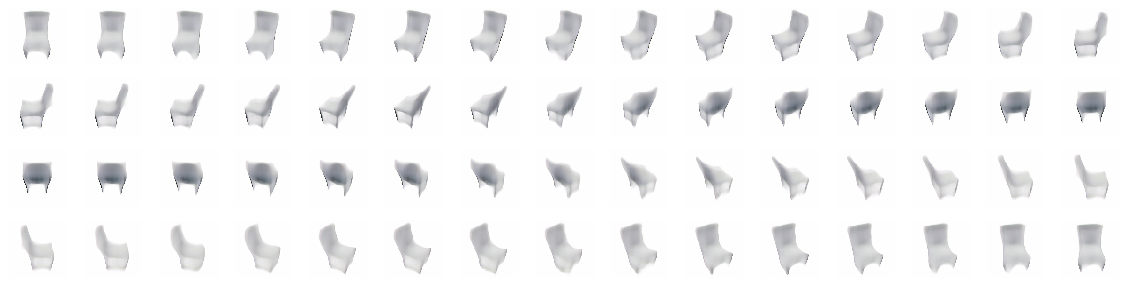

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2


plt.figure(figsize=(20,5))
for i in range(60):
    plt.subplot(4,15,i+1)
    plt.imshow(np.clip(predicts[i],0,1))
    plt.axis('off')